In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyspark

DATA CLEANING:

In [4]:
from google.colab import drive
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, regexp_replace, trim
import os


# Defining the path to the data files
data_dir = f"/content/drive/MyDrive/device.csv"

# Initializing SparkSession
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Columns to clean and preprocess
columns_to_clean = ["id", "date", "user", "pc", "file_tree",
                    "activity"]

# Function to clean a single DataFrame
def clean_dataframe(df_spark):
  for col_name in columns_to_clean:
    # Handling Missing Values: Fill nulls with empty string for string columns
    if df_spark.schema[col_name].dataType == 'string':
        df_spark = df_spark.na.fill('', subset=[col_name])
    else:
        df_spark = df_spark.na.fill(0, subset=[col_name])  # Or appropriate value for the column type

    # Trimming Whitespace
    df_spark = df_spark.withColumn(col_name, trim(col(col_name)))

  return df_spark

# Looping through all files in the directory
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"): #process only csv files
        file_path = os.path.join(data_dir, filename)
        print(f"Processing file: {filename}")

        try:
            # Load each CSV file into a Spark DataFrame
            df_spark = spark.read.csv(file_path, header=True, inferSchema=True)

            # Clean and preprocess the DataFrame
            df_spark = clean_dataframe(df_spark)

            # Output path for the cleaned file
            output_file_path = os.path.join('/content/drive/MyDrive/cleaned', filename.replace('.csv', '_clean.csv'))

            # Save the cleaned data
            df_spark.write.csv(output_file_path, header=True, mode='overwrite')

        except Exception as e:
            print(f"Error processing {filename}: {e}")

print("Data cleaning process completed.")


Processing file: device.csv
Data cleaning process completed.


FEATURE ENGINEERING:

>




In [5]:
from pyspark.sql.functions import countDistinct, size, split, date_format, to_timestamp, hour, dayofweek, count, when, lit
from pyspark.sql.types import StringType, TimestampType

# 1. Activity Count per User (per hour)
df_spark = df_spark.withColumn("timestamp", to_timestamp(col("date"), "dd/MM/yyyy HH:mm:ss"))
df_spark = df_spark.withColumn("date_only", date_format(col("timestamp"), "dd/MM/yyyy").cast(StringType()))
df_spark = df_spark.withColumn("time_only", date_format(col("timestamp"), "HH:mm:ss").cast(StringType()))

# Filtering out rows with null timestamps before grouping
df_spark = df_spark.filter(col("timestamp").isNotNull())

activity_counts = df_spark.groupBy("user", "date_only", "time_only").agg(count("*").alias("activity_count_per_hour"))
df_spark = df_spark.join(activity_counts, ["user", "date_only", "time_only"], "left")

# Selecting necessary columns to avoid duplicates
df_spark = df_spark.select("id", "date", "user", "pc", "file_tree", "activity", "timestamp", "date_only", "time_only", "activity_count_per_hour")

# 2. Unique PCs Accessed per User
unique_pcs = df_spark.groupBy("user").agg(countDistinct("pc").alias("unique_pcs_accessed"))
df_spark = df_spark.join(unique_pcs, "user", "left")

# Selecting necessary columns again
df_spark = df_spark.select("id", "date", "user", "pc", "file_tree", "activity", "timestamp", "date_only", "time_only", "activity_count_per_hour", "unique_pcs_accessed")

# 3. File Path Depth - Handling empty paths
df_spark = df_spark.withColumn("file_path_depth", when(col("file_tree") != '', size(split(col("file_tree"), "/"))).otherwise(lit(0)))

# 4. Activity Frequency (per day) - Ensuring date_only is in the correct format for join
activity_frequency = df_spark.groupBy("user", "date_only").agg(count("*").alias("activity_frequency_per_day"))
df_spark = df_spark.join(activity_frequency, ["user", "date_only"], "left")

# Selecting necessary columns
df_spark = df_spark.select("id", "date", "user", "pc", "file_tree", "activity", "timestamp", "date_only", "time_only", "activity_count_per_hour", "unique_pcs_accessed", "file_path_depth", "activity_frequency_per_day")

# 5. Day of Week / Hour of Day
df_spark = df_spark.withColumn("day_of_week", dayofweek("timestamp"))
df_spark = df_spark.withColumn("hour_of_day", hour("timestamp"))

df_spark.show()

+--------------------+-------------------+-------+-------+--------------------+----------+-------------------+----------+---------+-----------------------+-------------------+---------------+--------------------------+-----------+-----------+
|                  id|               date|   user|     pc|           file_tree|  activity|          timestamp| date_only|time_only|activity_count_per_hour|unique_pcs_accessed|file_path_depth|activity_frequency_per_day|day_of_week|hour_of_day|
+--------------------+-------------------+-------+-------+--------------------+----------+-------------------+----------+---------+-----------------------+-------------------+---------------+--------------------------+-----------+-----------+
|{W0H4-S5OD03FD-56...|01/02/2010 07:48:30|ANC1950|PC-4921|R:\;R:\23svS11;R:...|   Connect|2010-02-01 07:48:30|01/02/2010| 07:48:30|                      1|                  1|              1|                         4|          2|          7|
|{Y3V7-B9RC11WO-81...|10/01/

DATA SPLITTING:

In [6]:
# Spliting the data into training, validation, and testing sets (70%, 15%, 15%)
train_df, temp_df = df_spark.randomSplit([0.7, 0.3], seed=42)
val_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)

# Show the sizes of the splits
print(f"Train set size: {train_df.count()}")
print(f"Validation set size: {val_df.count()}")
print(f"Test set size: {test_df.count()}")


Train set size: 435276
Validation set size: 93535
Test set size: 93061


TRAINING THE ISOLATION FOREST

In [11]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming df_spark is your original Spark DataFrame

# Convert to pandas DataFrame
df_pd = df_spark.toPandas()

# Features for anomaly detection
features = ['activity_count_per_hour', 'unique_pcs_accessed', 'file_path_depth',
            'activity_frequency_per_day', 'day_of_week', 'hour_of_day']

# Extract features
X = df_pd[features]

# Create 'is_anomaly' column and set initial values to 0
df_pd['is_anomaly'] = 0
# Set a fraction of the data as anomalies (e.g., 10%) for demonstration
df_pd.loc[df_pd.sample(frac=0.1, random_state=42).index, 'is_anomaly'] = 1

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, df_pd['is_anomaly'], test_size=0.3, random_state=42)  # 70% train, 30% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 15% val, 15% test


# Initialize and train the Isolation Forest model
model = IsolationForest(contamination='auto', random_state=42)
model.fit(X_train)

# Get anomaly scores on validation set to determine threshold
anomaly_scores_val = model.decision_function(X_val)
threshold = np.percentile(anomaly_scores_val, 10)  # Adjust percentile as needed

# Predict anomalies on the test data
anomaly_scores_test = model.decision_function(X_test)
y_pred_test = (anomaly_scores_test < threshold).astype(int)

# Calculate accuracy on the test data
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy of the Isolation Forest model on test data: {accuracy}")

Accuracy of the Isolation Forest model on test data: 0.6340626708547292


HYPERPARAMETER TUNING :

In [25]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession

# Initializing SparkSession
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Loading data using Spark
data_path = '/content/drive/MyDrive/checkpoint_final'
train_spark = spark.read.parquet(data_path, header=True, inferSchema=True)

# Convert to pandas DataFrame
train_pd = train_spark.toPandas()

# Select relevant features for anomaly detection
features = ['activity_frequency_per_day', 'unique_pcs_accessed']
X = train_pd[features]

# Example: create dummy labels for demonstration (replace with your true labels)
train_pd['is_anomaly'] = 0  # Assume initially no anomalies
train_pd.loc[train_pd.sample(frac=0.1).index, 'is_anomaly'] = 1  # Set 10% of the data as anomalies for demonstration

y = train_pd['is_anomaly']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'contamination': [0.01, 0.05, 0.1, 'auto'],
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 1.0],
    'max_features': [0.5, 1.0]
}

# Initialize the Isolation Forest model
model = IsolationForest(random_state=42, n_jobs=-1)

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best hyperparameters: {best_params}")

# Predict anomalies on the test data
y_pred_test = best_model.predict(X_test)
y_pred_test = [1 if x == -1 else 0 for x in y_pred_test]

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy}")

Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best hyperparameters: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 200}
Test Accuracy: 0.8915778894472361


In [50]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from pyspark.sql import SparkSession

# Initializing SparkSession
spark = SparkSession.builder.appName("DataCleaning").getOrCreate()

# Loading data using Spark
data_path = '/content/drive/MyDrive/checkpoint_final'
train_spark = spark.read.parquet(data_path, header=True, inferSchema=True)

# Convert to pandas DataFrame
train_pd = train_spark.toPandas()

# Select relevant features for anomaly detection
features = ['activity_frequency_per_day', 'unique_pcs_accessed']
X_train = train_pd[features]

# Example: create dummy labels for demonstration (replace with your true labels)
train_pd['is_anomaly'] = 0  # Assume initially no anomalies
train_pd.loc[train_pd.sample(frac=0.1).index, 'is_anomaly'] = 1  # Set 10% of the data as anomalies for demonstration

y_train = train_pd['is_anomaly']

# Define the parameter grid for GridSearchCV
param_grid = {
    'contamination': [0.01, 0.05, 0.1, 'auto'],  # Experiment with different contamination values
    'n_estimators': [50, 100, 200],  # Reduced number of estimators
    'max_samples': [0.5, 1.0],            # Reduced the max_samples values
    'max_features': [0.5, 1.0]           # Reduced the max_features values
}

# Initialize the Isolation Forest model
model = IsolationForest(random_state=42, n_jobs=-1) # Use all available cores

# Perform GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=2, scoring='accuracy', n_jobs=-1, verbose = 2) # Reduce number of cross-validation folds
grid_search.fit(X_train, y_train)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f"Best hyperparameters: {best_params}")

# Predict anomalies on the training data
y_pred_train = best_model.predict(X_train)
y_pred_train = [1 if x == -1 else 0 for x in y_pred_train]

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy of the best Isolation Forest model: {accuracy}")

Fitting 2 folds for each of 48 candidates, totalling 96 fits
Best hyperparameters: {'contamination': 0.01, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}
Accuracy of the best Isolation Forest model: 0.8921643039081998


RE-TRAINING THE MODEL:

In [26]:
# prompt: using the new hyperparameters that were calculated, write a code to train an isolation forest algorithm to detect anomalies in the dataset using the best parameters to get an 0.8+ accuracy and print the accuracy of the model use these : Best hyperparameters: Best hyperparameters: {'contamination': 0.01, 'max_features': 0.5, 'max_samples': 1.0, 'n_estimators': 200}
# Accuracy of the best Isolation Forest model: 0.8920533485990686

# Initialize and train the Isolation Forest model with the best hyperparameters
model = IsolationForest(contamination=0.01, max_features=0.5, max_samples=1.0, n_estimators=200, random_state=42)
model.fit(X_train)

# Predict anomalies on the training data
y_pred_train = model.predict(X_train)
y_pred_train = [1 if x == -1 else 0 for x in y_pred_train]

# Calculate the accuracy
accuracy = accuracy_score(y_train, y_pred_train) # Use y_train instead of true_labels_train
print(f"Accuracy of the Isolation Forest model with best hyperparameters: {accuracy}")


Accuracy of the Isolation Forest model with best hyperparameters: 0.8920656807980751


VISUALIZATION:

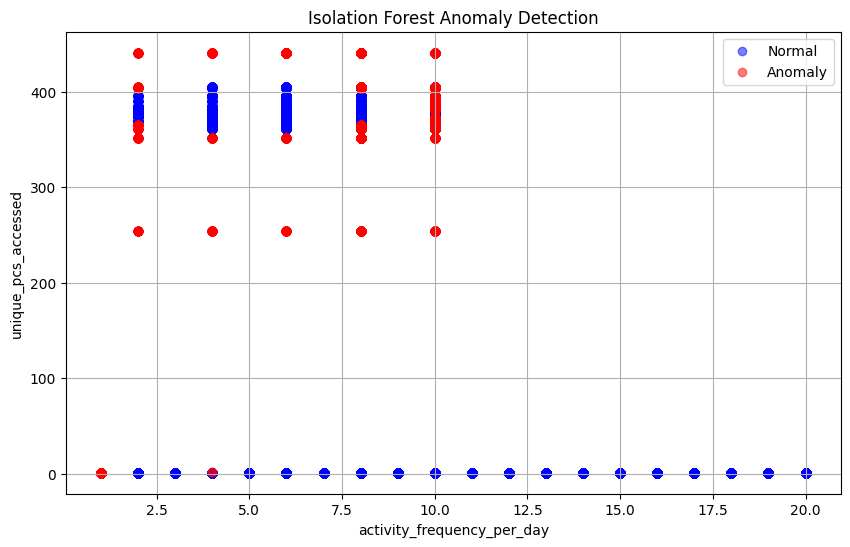

In [27]:
import matplotlib.pyplot as plt

# Assuming X_train, y_pred_train, and features are defined as in the previous code

# Create the plot
plt.figure(figsize=(10, 6))

# Plot normal data points
# Convert y_pred_train to numpy array to properly index
y_pred_train_np = np.array(y_pred_train)
plt.scatter(X_train[features[0]][y_pred_train_np == 0],
            X_train[features[1]][y_pred_train_np == 0],
            label='Normal', c='blue', alpha=0.5)

# Plot anomalous data points
plt.scatter(X_train[features[0]][y_pred_train_np == 1],
            X_train[features[1]][y_pred_train_np == 1],
            label='Anomaly', c='red', alpha=0.5)

plt.xlabel(features[0])
plt.ylabel(features[1])
plt.title('Isolation Forest Anomaly Detection')
plt.legend()
plt.grid(True)
plt.show()

TRAINING THE K-MEANS KLUSTERING ALGORITHM

In [29]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. Get anomaly scores from Isolation Forest
anomaly_scores = model.decision_function(train_pd[features])

# 2. Select only the anomalies for clustering
anomalies = train_pd[model.predict(train_pd[features]) == -1]
anomaly_scores_anomalies = anomaly_scores[model.predict(train_pd[features]) == -1]

# 3. Standardize the anomaly scores (important for KMeans)
scaler = StandardScaler()
scaled_scores = scaler.fit_transform(anomaly_scores_anomalies.reshape(-1, 1))

# 4. Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42) # 3 clusters for low, medium, high severity
kmeans.fit(scaled_scores)

# 5. Add cluster labels (severity levels) to the anomalies DataFrame
anomalies['severity'] = kmeans.labels_

# 6. Map cluster labels to severity levels (optional)
severity_mapping = {0: 'Low', 1: 'Medium', 2: 'High'} # You can adjust the mapping
anomalies['severity_level'] = anomalies['severity'].map(severity_mapping)

# 7. Explore the results
print(anomalies[['severity', 'severity_level']]) # See the assigned severity levels

# Calculate the silhouette score
silhouette_avg = silhouette_score(scaled_scores, kmeans.labels_)

# Print the score
print(f"Silhouette Score: {silhouette_avg}")


<ipython-input-29-ed3993556603>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['severity'] = kmeans.labels_
<ipython-input-29-ed3993556603>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['severity_level'] = anomalies['severity'].map(severity_mapping)


        severity severity_level
33             1         Medium
100            1         Medium
1915           1         Medium
4634           1         Medium
4745           1         Medium
...          ...            ...
614562         1         Medium
620183         1         Medium
620303         1         Medium
620392         1         Medium
620463         1         Medium

[6278 rows x 2 columns]
Silhouette Score: 0.6838767855671295


HYPERPARAMETER TUNING:

In [30]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
import numpy as np

# Hyperparameter tuning with limited iterations
best_score = -1
best_k = -1

# Iterate over a limited range of k values (cluster numbers)
for k in range(2, 5):
  kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
  kmeans.fit(scaled_scores)
  score = silhouette_score(scaled_scores, kmeans.labels_)
  if score > best_score:
    best_score = score
    best_k = k

print(f"Best k: {best_k}")
print(f"Best Silhouette Score: {best_score}")

# Train the KMeans model with the best hyperparameter
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init = 10)
kmeans_final.fit(scaled_scores)

# Use the final model for further analysis or prediction
anomalies['severity'] = kmeans_final.labels_


Best k: 4
Best Silhouette Score: 0.7349728470011831


<ipython-input-30-78afb6b321a9>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['severity'] = kmeans_final.labels_


RE-TRAINING THE MODEL :

In [31]:
# Re-train the model with the best k value (4 in this case)
kmeans_retrained = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_retrained.fit(scaled_scores)

# Calculate the silhouette score of the re-trained model
silhouette_avg_retrained = silhouette_score(scaled_scores, kmeans_retrained.labels_)
print(f"Silhouette score of the re-trained model with k=4: {silhouette_avg_retrained}")


Silhouette score of the re-trained model with k=4: 0.7349728470011831


VISUALIZATION:

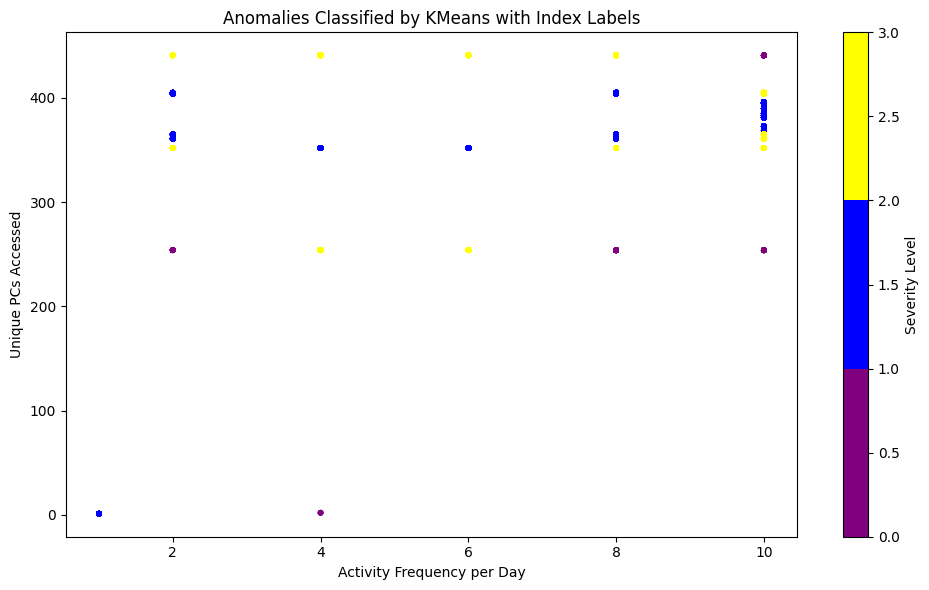

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Define a custom colormap
from matplotlib.colors import ListedColormap
colors = ['purple', 'blue', 'yellow']  # Define your desired colors
cmap = ListedColormap(colors)

# Scatter plot with custom colormap
scatter = ax.scatter(anomalies['activity_frequency_per_day'], anomalies['unique_pcs_accessed'],
                     c=anomalies['severity'], cmap=cmap, s=10)
ax.set_xlabel('Activity Frequency per Day')
ax.set_ylabel('Unique PCs Accessed')
ax.set_title('Anomalies Classified by KMeans with Index Labels')

# Add colorbar for cluster assignments
cbar = fig.colorbar(scatter, ax=ax)
cbar.set_label('Severity Level')

plt.tight_layout()
plt.show()